# Mini-project: Horror / non-Horror collection

We've put some effort into building our collection. Now it's time to learn something about it. You already have lots of excellent ideas for how to apply the tools we've learned about so far. It's also a good time of the semester to review what we have learned and practice applying it in less structured settings.

You will work in groups of 2-4 to do a short project applying code from the previous weeks to this collection. You will turn in a completed project as a notebook with the following sections:

1. Question(s). Describe what you wanted to learn. Suggest several possible answers or hypotheses, and describe in general terms what you might expect to see if each of these answers were true (save specific measurements for the next section). For example, many students want to know the difference between horror and non-horror, but there are many ways to operationalize this question. 

2. Methods. Describe how you will use computational methods presented so far in this class to answer your question. What do the computational tools do, and how does their output relate to your question? Describe how you process the collection into a form suitable for a model or algorithm.

3. Code. Code should be correct (no errors) and focused (unneeded code from examples is removed). Use the notebook format effectively: code may be incorporated into multiple sections.

4. Results. Use sorted lists, tables, and visual presentations to make your argument. Excellent projects will provide multiple views of results, and follow up on any apparent outliers or strange cases, including through careful reading of the original documents.

5. Reflection. Describe your experience in this process. What was harder or easier than you expected? What compromises or negotiations did you have to accept to match the collection, the question, and the methods? What would you try next? 

6. Responsibility. Describe each team member's contribution. Credit any online sources (stack overflow, blog posts, documentation) that you found helpful.

We will grade this work based on accuracy, thoroughness, creativity, reflectiveness, and quality of presentation. Scope: this is a *mini*-project, with a short deadline. We are expecting work that is consistent with that timeframe.

In [117]:
import csv, sys, os, re
import numpy as np
import spacy
from sklearn.cluster import KMeans

import collections
from collections import Counter
import matplotlib.pyplot as plt
from scipy import fftpack

In [118]:
word_pattern = re.compile("\w[\w\-\']*\w|\w")

documents = []

with open("../data/Gutenberg-2019-10-21/metadata.csv", encoding="utf-8") as reader:
    csv_reader = csv.DictReader(reader)
    for document in csv_reader:
        try:
            with open("../data/Gutenberg-2019-10-21/{}".format(document["Filename"]), encoding="utf-8") as reader:
                print(document["Author"] + " / " + document["Title"])

                lines = []
                for line in reader:
                    lines.append(line.rstrip())

                text = " ".join(lines)
                document["Text"] = text
                document["Tokens"] = word_pattern.findall(text)
                
                documents.append(document)
        except Exception as e:
            print(f'Problem with {document["Filename"]}: {e}')

Austen, Jane / Emma
Austen, Jane / Persuasion
Austen, Jane / Pride and Prejudice
Austen, Jane / Sense and Sensibility
Problem with baring_gould_the_book_of_werewolves_pg5324.txt: [Errno 2] No such file or directory: '../data/Gutenberg-2019-10-21/baring_gould_the_book_of_werewolves_pg5324.txt'
Baum, Lyman Frank / Glinda of Oz
Baum, Lyman Frank / The Wonderful Wizard of Oz
Beckford, William / Vathek
Problem with beckford_vathek_an_arabian_tale_pg42401.txt: 'utf-8' codec can't decode byte 0xd2 in position 1716: invalid continuation byte
Bierce, Ambrose / An Occurrence at Owl Creek Bridge
Bierce, Ambrose / Present at a Hanging and Other Ghost Stories
Bierce, Ambrose / The Parenticide Club
Bierce, Ambrose / The Damned Thing
Birkhead, Edith / The Tale of Terror
Problem with edith_the_tale_of_terror_pg14154.txt: 'utf-8' codec can't decode byte 0xe9 in position 6657: invalid continuation byte
Blackwood, Algernon / The Damned
Blackwood, Algernon / The Willows
Blackwood, Algernon / Four Weird Ta

Wilde, Oscar / An Ideal Husband 
Wodehouse, P.G. / A Damsel in distress
Problem with wodehouse_a_damsel_in_distress_pg2233.txt: 'utf-8' codec can't decode byte 0x99 in position 1592: invalid start byte


In [119]:
SECTIONS = 100
# we will now split each document into  even sections based on word count
split_documents = collections.defaultdict(dict)

for doc in documents:
    section_size = int(len(doc["Tokens"]) / SECTIONS)
    split_documents[doc["Title"]]["Sections"] = [doc["Tokens"][(section_size*i):(section_size*(i+1))] for i in range(SECTIONS - 1)]
    
    # special case for the last index if length isn't divisible by SECTIONS
    split_documents[doc["Title"]]["Sections"].append(doc["Tokens"][(section_size*(SECTIONS-1)):len(doc["Tokens"])])

In [120]:
# taken from week3

word_weights = {}
with open("../week3/bingliu.csv") as lexicon_reader:
    for line in lexicon_reader:
        weight, word = line.rstrip().split(",") ## split on comma
        word_weights[word] = float(weight) ## convert string to number

In [121]:
def score(text):
    counter = Counter(text)
    score = 0
    for token in counter.keys():
        token = token.lower()
        if token in word_weights:
            score += counter[token] * word_weights[token]
    return score / len(counter)

In [122]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "entity_linker", "textcat", "entity_ruler"])

for doc in documents:
    split_documents[doc["Title"]]["Sentiment"] = [score(sec) for sec in split_documents[doc["Title"]]["Sections"]]
    print (doc["Title"])



Emma
Persuasion
Pride and Prejudice
Sense and Sensibility
Glinda of Oz
The Wonderful Wizard of Oz
An Occurrence at Owl Creek Bridge
Present at a Hanging and Other Ghost Stories
The Parenticide Club
The Damned Thing
The Damned
The Willows
Four Weird Tales
Day and Night Stories
The Wendigo
A Sweet Little Maid
Jane Eyre: An Autobiography
Wuthering Heights
Bulfinch's Mythology
The Odyssey
Alice's Adventures in Wonderland
The Murder on the Links
The Secret Adversary
The Moonstone
Heart of Darkness
La Grande Breteche
A Christmas Carol
Great Expectations
A Tale of Two Cities
Oliver Twist
A Christmas Carol
A Study in Scarlet
Tales of Terror and Mystery
The Adventure Of Sherlock Holmes
The Hound of The Baskervilles
The Parasite
Round the Fire Stories
The Three Musketeers
The Man in the Iron Mask
The Count of Monte Cristo
The Book of Wonder
The Used People Lot
The House of the White Shadows
The Beautiful and the Damned
This Side of Paradise
The Markenmore Mystery
The Middle of Things
Clarimonde


In [123]:
def plot_scores(scores, title):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('Narrative Progression')
    ax.set_ylabel('Sentiment Score')
    ax.set_title(title)
    x = np.linspace(0, 100, 100)
    ax.plot(x, scores)
    plt.show()

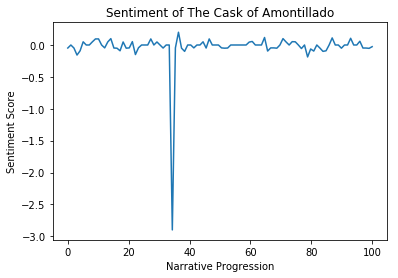

In [124]:
# plotting an outlier
s = split_documents["The Cask of Amontillado"]["Sentiment"]
plot_scores(s, "Sentiment of The Cask of Amontillado")

In [125]:
def fft_smooth(scores):
    time_step = 0.01
    sig_fft = fftpack.fft(scores)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(len(scores), d=time_step)
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]
    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)
    return [np.real(x) for x in filtered_sig]

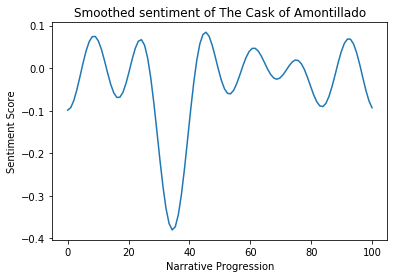

In [126]:
plot_scores(fft_smooth(s), "Smoothed sentiment of The Cask of Amontillado")

In [127]:
sentiment = np.zeros((120, 100))
smooth_sentiment = np.zeros((120, 100))
names = []
i = 0
for key in split_documents:
    sentiment[i] = split_documents[key]['Sentiment']
    smooth_sentiment[i] = fft_smooth(split_documents[key]['Sentiment'])
    names.append(key)
    i += 1

In [128]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(sentiment)
smooth_kmeans = KMeans(n_clusters=4, random_state=0).fit(smooth_sentiment)

In [129]:
U,S,Vt = np.linalg.svd(sentiment)

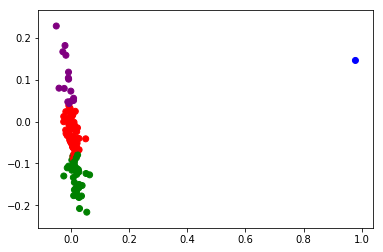

In [131]:
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[kmeans.labels_[i]] for i in range(len(sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

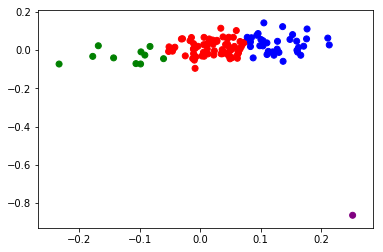

In [132]:
U,S,Vt = np.linalg.svd(smooth_sentiment)
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[smooth_kmeans.labels_[i]] for i in range(len(smooth_sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

In [133]:
del split_documents["The Cask of Amontillado"]

In [160]:
n_clusters = 4
sentiment = np.zeros((120, 100))
smooth_sentiment = np.zeros((120, 100))
i = 0
for key in split_documents:
    sentiment[i] = split_documents[key]['Sentiment']
    smooth_sentiment[i] = fft_smooth(split_documents[key]['Sentiment'])
    i += 1
    
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(sentiment)
smooth_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(smooth_sentiment)

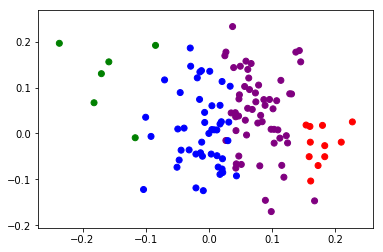

In [161]:
U,S,Vt = np.linalg.svd(sentiment)
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[kmeans.labels_[i]] for i in range(len(sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

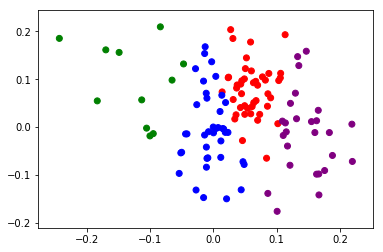

In [162]:
U,S,Vt = np.linalg.svd(smooth_sentiment)
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[smooth_kmeans.labels_[i]] for i in range(len(smooth_sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

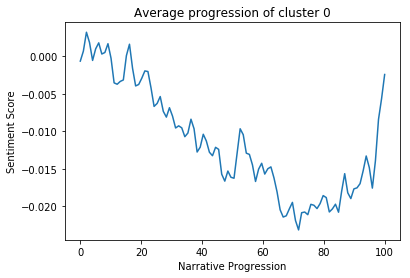

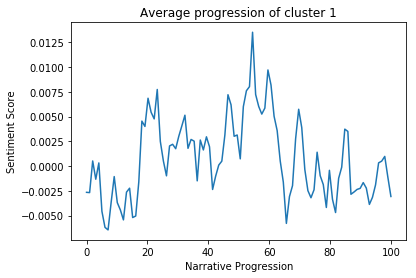

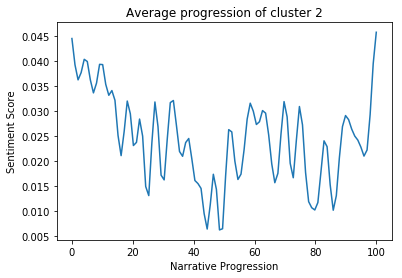

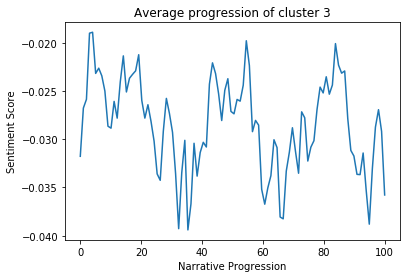

In [163]:
# plot average of each cluster
labels = list(smooth_kmeans.labels_)
for i in range(n_clusters):
    cluster_sent = np.array([smooth_sentiment[x] for x in range(len(smooth_sentiment)) if labels[x] == i])
    avg_sent = np.mean(cluster_sent, axis = 0)
    plot_scores(avg_sent, "Average progression of cluster "+str(i))
    

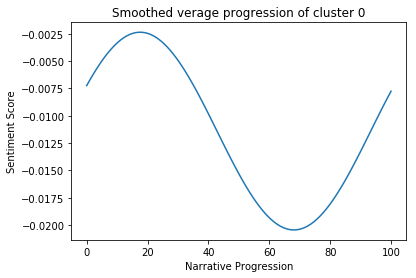

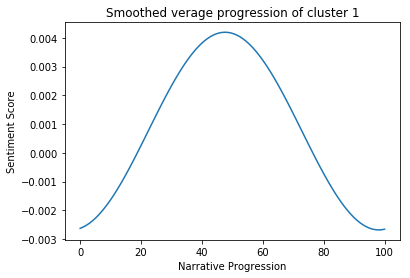

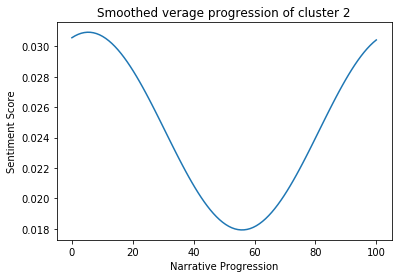

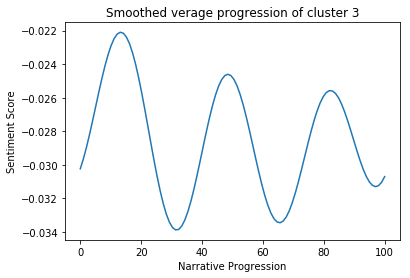

In [164]:
# plot smoothed average of each cluster
labels = list(smooth_kmeans.labels_)
for i in range(n_clusters):
    cluster_sent = np.array([smooth_sentiment[x] for x in range(len(smooth_sentiment)) if labels[x] == i])
    avg_sent = fft_smooth(list(np.mean(cluster_sent, axis = 0)))
    plot_scores(avg_sent, "Smoothed verage progression of cluster "+str(i))
    